In [1]:
!nvidia-smi

Wed Jan  6 13:08:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   39C    P2    52W / 250W |    859MiB / 11177MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        # additional state condenser. 2*2 is bidirectional * (cell+hidden), reduce down to hidden_dim
        self.state_condenser = nn.Linear(2*2*hidden_dim, hidden_dim)
        # dropout
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        # LSTM take input as [length, batch, emb], which is already formatted in BucketIterator
        lstm_seq, lstm_state = self.lstm(embeds)
        hidden_state, cell_state = lstm_state
        # states are both [2, batch_size, hidden_dim], cat + transpose
        batch_size = lstm_seq.shape[1]
        condensed_state = self.state_condenser(torch.cat(lstm_state, dim=0).transpose(0, 2)
                                                   .contiguous().view(batch_size, 2*2*self.hidden_dim))
        # apply dropout
        condensed_state = self.dropout(condensed_state)
        lstm_seq = self.dropout(lstm_seq)
        return condensed_state, lstm_seq

In [4]:
class LayeredOutput(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super(LayeredOutput, self).__init__()
        self.hidden_dim = hidden_dim
        self.internal_layer = nn.Linear(hidden_dim, hidden_dim * 2)
        # dropout
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, inputs, num_apply_layer=3):
        # input in form of [batch_size, hidden_dim]
        batch_size = inputs.shape[0]
        inputs = inputs.view(batch_size, 1, self.hidden_dim)
        outputs = [inputs]
        for i in range(num_apply_layer):
            next_output = self.internal_layer(outputs[-1]).view(batch_size, -1, self.hidden_dim)
            outputs.append(next_output)
        # output in form of [batch_size, 2^n-1, hidden_dim], need to transpose to fit BucketIterator form
        return torch.cat(outputs, dim=1).transpose(0, 1)

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.q_layer = nn.Linear(hidden_dim, hidden_dim)
        self.k_layer, self.v_layer = [nn.Linear(hidden_dim * 2, hidden_dim) for _ in range(2)]
    
    def forward(self, querries, keys, mask=None):
        # querries in [2^n-1, batch_size, hidden_dim], transpose them back first, linear the last dimension
        # keys should be [src_len, batch_size, hidden_dim] already, so we transpose keys to [batch_size, hidden_dim, src_len] 
        # and values as [batch_size, src_len, hidden_dim]
        querries = self.q_layer(querries.transpose(0, 1))
        keys, values = self.k_layer(keys), self.v_layer(keys)
        keys = keys.permute(1, 2, 0); values = values.transpose(0, 1)
        # attention should be [batch_size, 2^n-1, src_len], in log form.
        # TODO add scale as option
        log_attention = torch.matmul(querries, keys)
        if(mask is not None):
            # mask should be [src_len, batch_size] of bools to remove all padding in src. False is pad
            mask = mask.transpose(0, 1).unsqueeze(1)
            neginf_pad = (torch.ones(log_attention.shape) * -1e10).to(mask.device)
            log_attention = torch.where(mask, log_attention, neginf_pad)
        attention = nn.functional.softmax(log_attention, dim=2)
        # print(attention.shape, values.shape)
        # we want to matmul values and attention [batch_size, 2^n-1, src_len] * [batch_size, src_len, hidden_dim] -> [batch_size, 2^n-1, hidden_dim]
        result = torch.matmul(attention, values)
        # also transpose to conform with querries
        return result.transpose(0, 1)

In [6]:
from torch.autograd import Variable
class TemplateOutput(Attention):
    def __init__(self, hidden_dim, template_num=128, dropout=0.2):
        # disregard Attention's init (calling grandparent)
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        # mimic the querries format
        self.keys = torch.nn.Parameter(torch.randn(template_num, 1, hidden_dim).type(torch.FloatTensor))
        self.values = torch.nn.Parameter(torch.randn(template_num, 1, hidden_dim * 2).type(torch.FloatTensor))
        # override: load the keys regardless of the input value
        self.k_layer = lambda x: self.keys
        self.v_layer = lambda x: self.values
        # q layers are made as normal
        self.q_layer = nn.Linear(hidden_dim, hidden_dim)
        # dropout
        self.dropout = nn.Dropout(p=dropout)
    
    def regularization_loss(self, reduce=None):
        # extract losses using cosine distance between k & v. In effect, this cause the template to not repeat 
        # itself down to the lower level
        keys = F.normalize(self.keys, dim=-1) # batch x 1 x dim
        values = F.normalize(torch.squeeze(self.values, dim=1).reshape(keys.shape[0], 2, self.hidden_dim)) # batch x 2 x dim 
        transpose_values = torch.transpose(values, -2, -1)
        loss = torch.matmul(keys, transpose_values)
        if(reduce == "mean"):
            loss = torch.reduce_mean(loss)
        elif(reduce == "sum"):
            loss = torch.reduce_sum(loss)
        return loss
    
    def forward(self, inputs, num_apply_layer=3):
        batch_size = inputs.shape[0]
        inputs = inputs.view(batch_size, 1, self.hidden_dim)
        outputs = [inputs]
        for i in range(num_apply_layer):
            # use the attention on the templates, loading a mock key value (None). We do not need mask, as every entry is equal
            next_output = super(TemplateOutput, self).forward(outputs[-1], None)
            # reshape the next_output to [batch_size, 2^i, hidden_dim], effectively split the values
            next_output = next_output.contiguous().view(batch_size, -1, self.hidden_dim)
            # dropout
            next_output = self.dropout(next_output)
            outputs.append(next_output)
        # output in form of [batch_size, 2^n-1, hidden_dim], need to transpose to fit BucketIterator form
        result = torch.cat(outputs, dim=1).transpose(0, 1)
        return result

In [7]:
import torch.utils.data as torch_data
from torchtext.datasets import TranslationDataset
from torchtext.data import Example, Field
#torch_data = torchtext_data

class ManualDataset(TranslationDataset):
    def __init__(self, data, fields, **kwargs):
        fields = [('src', fields[0]), ('trg', fields[1])]
        examples = [Example.fromlist([src_ex, trg_ex], fields) for src_ex, trg_ex in zip(*data)]
        # use grandparent __init__
        super(TranslationDataset, self).__init__(examples, fields, **kwargs)

class Model(nn.Module):
    def __init__(self, data, hidden_dim, use_attention=True, dropout=0.2, **kwargs):
        super(Model, self).__init__(**kwargs)
        self.use_attention = use_attention
        fields = self.input_field, self.output_field = Field(lower=True, pad_token="<blank>"), Field(lower=True, pad_token="<blank>")
        # write later
        self._data = self.build_vocab(fields, data)
        # encoder
        self.encoder = Encoder(hidden_dim, hidden_dim, len(self.input_field.vocab), dropout=dropout)
        # tree decoder
        self.decoder = TemplateOutput(hidden_dim, dropout=dropout) #LayeredOutput(hidden_dim)
        if(use_attention):
            self.attention = Attention(hidden_dim)
            projection_input = hidden_dim * 2
        else:
            projection_input = hidden_dim
        # projection, adapt for both version
        self.projection = nn.Linear(projection_input, len(self.output_field.vocab))
    
    def init(self, method="xavier"):
        # init all parameters using specific values
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, num_apply_layer=3):
        #src = self.input_field(src)
        encoded_out, encoder_seq = self.encoder(src)
        output = self.decoder(encoded_out, num_apply_layer=num_apply_layer)
        if(self.use_attention):
            # create mask for src (values is NOT padding token). Shape is [src_len, batch_size]
            pad_id = self.input_field.vocab.stoi[self.input_field.pad_token]
            attention_mask = (src != pad_id).to(src.device)
            # tokens = [[self.input_field.vocab.itos[i] for i in sample] for sample in src.transpose(0, 1)]
            # raise ValueError("pad_token {}, \n{}\n{} - {}".format(pad_token, tokens, attention_mask, attention_mask.shape))
            # print(output.shape, encoder_seq.shape)
            # apply attention and concatenate to the last dimension (hidden_dim)
            attention_output = self.attention(output, encoder_seq, mask=attention_mask)
            output = torch.cat((output, attention_output), dim=2)
        projection = self.projection(output)
        return projection
    
    def build_vocab(self, fields, data):
        formatted_data = ManualDataset(data, fields) 
        # torch_data.Dataset([torch_data.Examples.fromlist([src_ex, tgt_ex], fields)
        #        for src_ex, trg_ex in zip(*data)], fields)
        [f.build_vocab(formatted_data) for f in fields]
        return formatted_data

In [8]:
!head -n10 /workspace/khoai23/example_tree_ende.lines.txt

<s> go <s> </s> </s> their <s> <blank> <blank> <blank> <blank> </s> </s> separate ways
<s> <s> <s> Orlando Bloom and <s> </s> </s> </s> </s> </s> </s> Miranda Kerr
<s> <s> <s> each other Actors <s> </s> </s> </s> </s> </s> </s> Orlando Bloom
<s> and <s> </s> </s> Model <s> <blank> <blank> <blank> <blank> </s> </s> Miranda Kerr
<s> still <s> </s> </s> love <s> <blank> <blank> <blank> <blank> </s> </s> each other
<s> , <s> </s> </s> in <s> <blank> <blank> <blank> <blank> </s> </s> an interview
<s> parents <s> </s> </s> to <s> <blank> <blank> <blank> <blank> </s> </s> two-year-old Flynn
<s> <s> <s> Miranda Kerr and <s> </s> </s> </s> </s> </s> </s> Orlando Bloom
<s> , <s> </s> </s> supermodel <s> <blank> <blank> <blank> <blank> </s> </s> Miranda Kerr
<s> <s> t life <s> </s> </s> </s> </s> doesn ' <blank> <blank> <blank> <blank>


In [9]:
import io
#sourcefile = ""
#targetfile = ""
# treefile = "/workspace/khoai23/example_tree_ende.lines.txt"
def loadTree(location):
    with io.open(location, "r", encoding="utf-8") as f:
        return [l.strip().split() for l in f.readlines()]
treefile = "/workspace/khoai23/train_tree_ende.lines.txt"
#with io.open(treefile, "r", encoding="utf-8") as f:
#    targets = [l.strip().split() for l in f.readlines()]
targets = loadTree(treefile)

In [10]:
# create the source phrase by correct tree position and ommiting keys
positions = [7, 3, 8, 1, 9, 4, 10, 0, 11, 5, 12, 2, 13, 6, 14]
def create_sources(tokens, reorder_positions, omissions=["<s>", "</s>", "<blank>"]):
    regtok = [tokens[i] for i in reorder_positions]
    return [tok for tok in regtok if tok not in omissions]
# apply
sources = [create_sources(ts, positions) for ts in targets]

In [11]:
# create the target/source pairing for 3 & 5 as well
def create_positions(depth):
    if(depth == 1): 
        return [0]
    prev_depth = create_positions(depth-1)
    # next_depth = range(2 ** (depth-1) - 1, 2 ** depth - 1)
    # interleave: next_depth will surround its parent node in prev_depth. Actually don't need the next depth either
    joined = []
    for i in prev_depth:
        if(i < 2 ** (depth-2) - 1):
            # belong to too-far-back depth, ignore
            joined.append(i)
        else:
            # intermediary node, append children
            joined.extend([i * 2 + 1, i, i * 2 + 2])
    return joined
test_pos_4 = create_positions(4)
assert all([x == y for x, y in zip(test_pos_4, positions)]), "{} - {}".format(test_pos_4, positions)

In [12]:
targets_3 = loadTree("/workspace/khoai23/train_tree_ende_3.lines.txt")
positions_3 = create_positions(3)
sources_3 = [create_sources(ts, positions_3) for ts in targets_3]

# 5 is not working
targets_5 = loadTree("/workspace/khoai23/train_tree_ende_5.lines.txt")
positions_5 = create_positions(5)
sources_5 = [create_sources(ts, positions_5) for ts in targets_5]

sources_4, positions_4, targets_4 = sources, positions, targets
sources = sources_3 + sources_4 + sources_5
targets = targets_3 + targets_4 + targets_5

In [13]:
print(list(zip(sources[:10], targets[:10])))

[(['Parliament', "'s", 'legislative', 'prerogative'], ['<s>', '<s>', '<s>', 'Parliament', "'s", 'legislative', 'prerogative']), (['purpose', 'and', 'extent'], ['<s>', 'purpose', '<s>', '</s>', '</s>', 'and', 'extent']), (['the', 'national', 'bureaucracies'], ['<s>', 'the', '<s>', '</s>', '</s>', 'national', 'bureaucracies']), (['null', 'and', 'void'], ['<s>', 'null', '<s>', '</s>', '</s>', 'and', 'void']), (['down', 'in', 'advance'], ['<s>', 'down', '<s>', '</s>', '</s>', 'in', 'advance']), (['Stretching', 'and', 'Pilates'], ['<s>', 'Stretching', '<s>', '</s>', '</s>', 'and', 'Pilates']), (['and', 'Postural', 'Gym'], ['<s>', 'and', '<s>', '</s>', '</s>', 'Postural', 'Gym']), (['personal', 'Trainer', 'and', 'Instructor'], ['<s>', '<s>', '<s>', 'personal', 'Trainer', 'and', 'Instructor']), (['Stretching', ',', 'Pilates'], ['<s>', 'Stretching', '<s>', '</s>', '</s>', ',', 'Pilates']), (['the', 'Italian', 'Federation'], ['<s>', 'the', '<s>', '</s>', '</s>', 'Italian', 'Federation'])]


In [14]:
class LabelSmoothingLoss(nn.Module):
    """
    With label smoothing,
    KL-divergence between q_{smoothed ground truth prob.}(w)
    and p_{prob. computed by model}(w) is minimized.
    
    Pulled from OpenNMT; adding special smoothing for specific tokens
    """
    def __init__(self, label_smoothing, tgt_vocab_size, ignore_index=-100, special_smoothing=None, special_indices=None):
        assert 0.0 < label_smoothing <= 1.0
        self.ignore_index = ignore_index
        super(LabelSmoothingLoss, self).__init__()

        smoothing_value = label_smoothing / (tgt_vocab_size - 2)
        one_hot = torch.full((tgt_vocab_size,), smoothing_value)
        one_hot[self.ignore_index] = 0
        self.register_buffer('one_hot', one_hot.unsqueeze(0))
        self.confidence = 1.0 - label_smoothing
        
        if(special_smoothing is not None):
            one_hot_s = torch.full((tgt_vocab_size,), special_smoothing / (tgt_vocab_size - 2))
            self.register_buffer('one_hot_s', one_hot_s.unsqueeze(0))
            self.confidence_s = 1.0 - special_smoothing
            def indices_check(target):
                is_special = target == special_indices[0]
                for i in special_indices[1:]:
                    is_special = torch.logical_or(is_special, target == i)
                return is_special
            self.indices_s = indices_check
        else:
            self.one_hot_s = None
            
        self.register_buffer('zeros', torch.zeros((tgt_vocab_size, )))

    def forward(self, output, target, reduction='batchmean'):
        """
        output (FloatTensor): batch_size x dim x n_classes
        target (LongTensor): batch_size x dim
        """
        # flatten both
        old_shape = output.shape
        target = target.reshape(-1)
        output = output.reshape(target.size(0), -1)
        # also output need to be log softmaxed
        output = F.log_softmax(output, dim=-1)
        
        model_prob = self.one_hot.repeat(target.size(0), 1)
        model_prob.scatter_(1, target.unsqueeze(1), self.confidence)
        # create and join the probs together
        if(self.one_hot_s is not None):
            s_prob = self.one_hot_s.repeat(target.size(0), 1)
            s_prob.scatter_(1, target.unsqueeze(1), self.confidence_s)
            # join: if true = special = use s_prob
            s_selector = self.indices_s(target)
            # raise ValueError(s_selector.shape, s_prob.shape, model_prob.shape)
            model_prob = torch.where(s_selector.unsqueeze(1), s_prob, model_prob)
        model_prob.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)
        output = torch.where((target == self.ignore_index).unsqueeze(1), self.zeros.unsqueeze(0), output)
        # rescale input before feeding to kl_div (same as cross entropy, save a constant value) to allow correct calculation of batchmean
        output = output.reshape(old_shape)
        model_prob = model_prob.reshape(old_shape)
        return F.kl_div(output, model_prob, reduction=reduction)

In [15]:
import torch.optim as optim

data = sources, targets
model = Model(data, 256)

blank_id = model.output_field.vocab.stoi['<blank>']
pad_id = model.output_field.vocab.stoi['<pad>']
unk_id = model.output_field.vocab.stoi['<unk>']
inner_id = model.output_field.vocab.stoi['<s>']
outer_id = model.output_field.vocab.stoi['</s>']
print(blank_id, pad_id, unk_id, inner_id, outer_id)

criterion = nn.CrossEntropyLoss(ignore_index=blank_id)
#criterion = LabelSmoothingLoss(0.2, len(model.output_field.vocab), ignore_index=blank_id,
#                              special_smoothing=0.5, special_indices=[inner_id])
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
graphview = False

1 0 0 3 2


### Main training loop

In [16]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

#fig = plt.figure()
#ax = fig.add_subplot(111)

graphview = True

Finished Training


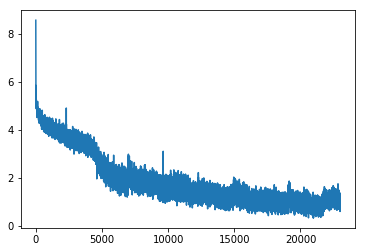

In [22]:
from torchtext.data import BucketIterator, interleave_keys

device="cuda"
model = model.to(device)
criterion = criterion.to(device)

model.init()

train_iter = BucketIterator(dataset = model._data, batch_size=32, train=True, shuffle=True, 
                              sort_key=lambda x: interleave_keys(len(x.src), len(x.trg)))
all_iter_count = 0

#if(graphview):
    #fig.show()
losses = []
running_loss = 0.0
for epoch in range(10):  # loop over the dataset multiple times
    
    for i, data in enumerate(train_iter):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.src, data.trg
        # override <pad> tokens
        #labels = torch.where(labels == pad_id, torch.ones(labels.shape, dtype=labels.dtype) * blank_id, labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # try ignoring inner label (<s>), by adding it into ignore_index label (blank)
        ignore_id = outer_id # model.output_field.vocab.stoi['</s>']
        # blank_id = model.output_field.vocab.stoi['<blank>']
        ignore_labels = torch.where(labels == ignore_id, torch.ones(labels.shape, dtype=labels.dtype).to(device) * blank_id, labels)

#        raise Exception(inputs.shape, labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # preventing weird data: only accept labels with correct expanding dimensions, otherwise throw KeyError
        # layer = 1 is the encoder's output, hence number of application is -1
        label_dim_dict = {(2 ** v - 1): v-1 for v in [3, 4, 5]}
        # forward + backward + optimize
        #print(label_dim_dict[labels.shape[0]])
        outputs = model(inputs, num_apply_layer=label_dim_dict[labels.shape[0]])
        #processed_labels = self.output_field(labels)
        # Criterion accept [batch, length] and [batch, vocab, length] respectively
        outputs = outputs.transpose(1, 2)
        #raise Exception(outputs.shape, labels.shape)
        loss = criterion(outputs, ignore_labels) # use ignore_labels to remove inner label
        loss.backward()
        # forgot gradient clipping. Fixing.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        running_loss += loss.item()
        all_iter_count += 1
        if (all_iter_count+1) % 1000 == 0:    # print every 1000 mini-batches
            print('[%2d, %5d] loss: %.3f' %
                  (epoch + 1, all_iter_count + 1, running_loss / 1000))
            running_loss = 0.0
            
            if(graphview):
                plt.clf()
                plt.plot(losses)
                display.display(plt.gcf())
                display.clear_output(wait=True)

print('Finished Training')

In [20]:
# test the finished model
model.eval()

test_input = ["the world is big".split()]
proc_input = model.input_field.process(test_input).to(device)
proc_input.shape

unproc_output = model(proc_input)
# note that the output is the logits version (not softmaxed)
proc_output = torch.nn.functional.log_softmax(unproc_output, dim=-1)
k=5
topk_probs, topk_id = torch.topk(proc_output, k=k, dim=-1)
topk_prbs = topk_probs[:, 0]
topk_toks = [[model.output_field.vocab.itos[tok] for tok in tokens] for tokens in topk_id[:, 0]] # remove the single dim
print(topk_toks)

[['<s>', ',', 'the', 'a', "'"], ['world', 'our', 'one', 'as', 'is'], ['world', 'as', 'case', '<s>', 'one'], ['world', 'our', 'one', 'as', 'term'], ['spacious', 'big', 'job', 'everyone', 'solution'], ['big', 'spacious', 'solution', 'question', 'breakfast'], ['world', 'case', 'term', 'rich', 'people'], ['world', 'our', 'the', 'is', 'one'], ['world', 'case', '<s>', 'as', 'one'], ['big', 'solution', 'spacious', 'question', 'breakfast'], ['world', 'case', 'term', 'bank', 'largest'], ['big', 'spacious', 'solution', 'question', 'breakfast'], ['world', 'case', 'term', 'bank', 'rich'], ['<s>', 'the', 'a', ',', 'and'], ['<s>', 'really', ',', 'too', 'also']]


In [21]:
import math

#print (model.output_field.vocab.stoi['<s>'], model.output_field.vocab.stoi['</s>'])

prbs = topk_prbs.tolist()
toks = topk_toks
def load_node(index):
    # filter unwanted tokens
    return [(prob, s) for prob, s in zip(prbs[index], toks[index]) if s != '<s>' and s != "</s>"]
 
def best_per_node(parent, leftchild, rightchild, k=5):
    # combine left and right
    combined = [((lp + rp)/2, ls + ' ' + rs) for lp, ls in leftchild for rp, rs in rightchild]
    # all probabilities & corresponding str
    alls = parent + combined
    best_zipped = sorted(alls, key=lambda x:x[0], reverse=True)[:k]
    return best_zipped

# start with the lowest, and go up from there
node7 = load_node(7); node8 = load_node(8); node9 = load_node(9); node10 = load_node(10);
node11 = load_node(11); node12 = load_node(12); node13 = load_node(13); node14 = load_node(14);
# 3-7-8, etc.
node3 = best_per_node(load_node(3), node7, node8)
node4 = best_per_node(load_node(4), node9, node10)
node5 = best_per_node(load_node(5), node11, node12)
node6 = best_per_node(load_node(6), node13, node14)
# 1-3-4, 2-5-6
node1 = best_per_node(load_node(1), node3, node4)
node2 = best_per_node(load_node(2), node5, node6)
# 0-1-2
node0 = best_per_node(load_node(0), node1, node2)

print(node0)

[(-0.000972747802734375, 'world world'), (-0.013129711151123047, 'world big world world'), (-0.01325082778930664, 'world world big world world'), (-0.013383865356445312, 'world big world world'), (-0.025540828704833984, 'world big world big world world')]
